# Setup


In [7]:
import numpy as np
from scipy import optimize, stats
import matplotlib.pyplot as plt

## Environments

### Definitions

In [8]:
class Environment:
    def __init__(self):
        pass

    def round(self, p_t):
        sold = int(p_t <= self.valuations[self.t]) # Customer buys if p <= v
        r_t = (p_t - self.cost) * sold
        self.rewards[self.t] = r_t
        self.t += 1
        return r_t / 100

    def get_valuations(self):
        return self.valuations

    def plot_valuations(self, T, K):
        plt.figure(figsize=(10, 6))
        for k in range(K):
            plt.plot(range(T), self.valuations[:, k], marker='o', label=f'Item {k+1}')

        plt.xlabel('Round')
        plt.ylabel('Valuation')
        plt.title('Valuations Over Time')
        plt.ylim(0, 100)
        plt.grid(True)
        plt.show()

In [9]:
class StochasticEnvironment(Environment):
    def __init__(self, cost, var, T, K):
        self.valuations = np.random.normal(loc=50, scale=var, size=(T,K)) % 100
        self.cost = cost
        self.rewards = np.zeros(T)
        self.t = 0

In [10]:
class AdversarialEnvironment(Environment):
    def __init__(self, cost, step, T, K):
        self.valuations = np.zeros((T, K), dtype=int)
        self.cost = cost
        self.rewards = np.zeros(T)
        self.t = 0

        for t in range(int(T / step)):
            # after "step" rounds, we change mean and variance
            mean = (np.random.rand() * 100) % 100
            var = np.random.rand() * 30

            for i in range(step):
                vals = np.random.normal(loc=mean, scale=var, size=K)
                vals = np.round(vals) % 100   # wrap-around to get rid of out of range values
                self.valuations[t * step + i] = vals.astype(int)

### Tests

In [12]:
T = 250
K = 1

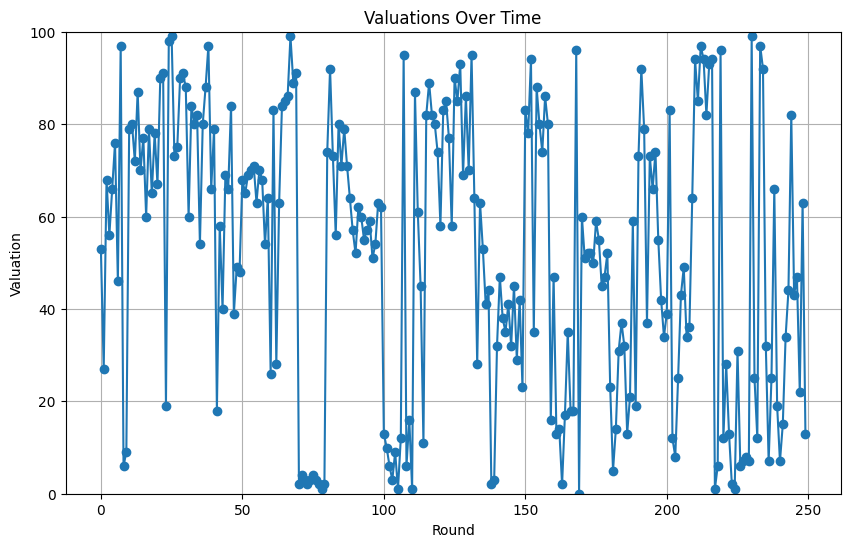

In [13]:
adv = AdversarialEnvironment(cost = 5, step = 10, T = T, K = K)
adv.plot_valuations(T, K)

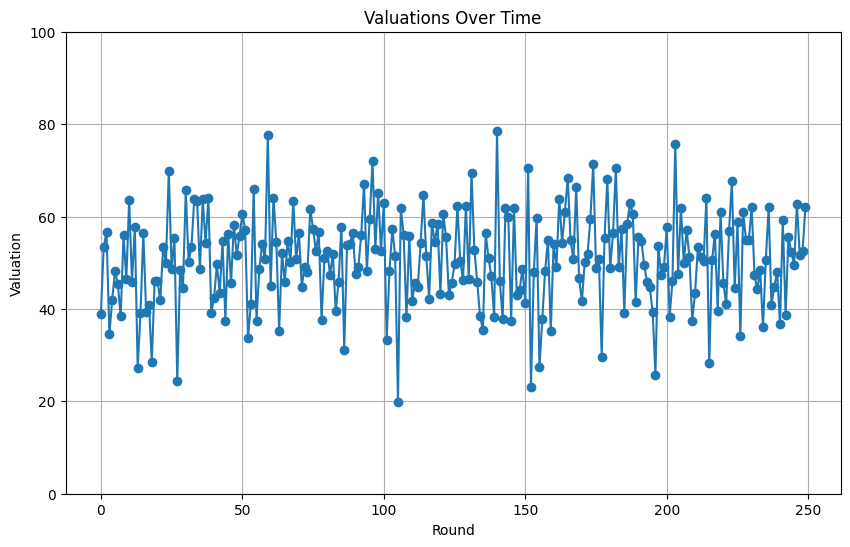

In [14]:
stc = StochasticEnvironment(cost = 5, var = 10, T = T, K = K)
stc.plot_valuations(T, K)

## Agents

### Definitions

In [19]:
class Agent:
    def __init__(self):
        pass
    def pull_arm(self):
        pass
    def update(self, r_t):
        pass

    # Solves the optimization problem
    def compute_opt(self, f_ucbs, c_lcbs, rho):
        N, K = self.N, self.K

        # Add the "do not sell" arm, with utility 0 and consumption 0
        f_ucbs = np.hstack([np.zeros(1), f_ucbs])
        c_lcbs = np.hstack([np.zeros(1), c_lcbs])

        c_obj = -f_ucbs.flatten()

        A_ub = [c_lcbs.flatten()]
        b_ub = [rho]
        bounds = (0, 1)

        # Equality constraints: sum of each row = 1
        A_eq = np.zeros((N, N * (K + 1)))
        b_eq = np.ones(N)
        for i in range(N):
            for j in range(K + 1):
                A_eq[i, i * (K + 1) + j] = 1

        res = optimize.linprog(c=c_obj, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs-ds")

        if res.success:
            gamma = res.x.reshape(K + 1)
        else:
            gamma = np.zeros(K)

        return gamma

In [20]:
class UCB1Agent(Agent):
    def __init__(self, T, N=1):
        self.N = N                          # Customers
        self.K = int(1 /( T ** (-1/3)))     # Optimal qutization (from theory)
        self.q = ( T ** (-1/3)) * 100       # Price quant
        self.T = T                          # Rounds
        self.a_t = None
        self.t = 0

        # UCB1 internals
        self.average_rewards = np.zeros(self.K, dtype=np.float64)   # Empirical average of rewards
        self.N_pulls = np.zeros(self.K, dtype=int)  + 1e-9          # Times each arm has been pulled
        self.avg_c = np.ones(self.K, dtype=np.float64)              # Empirical average of consumption

        self.rewards = np.zeros(self.T)     # Rewards log

    def pull_arm(self, B):
        if self.t < self.K:     # Explore all arms first
            self.a_t = self.t
        else:
            f_ucbs = self.average_rewards + np.sqrt(2*np.log(self.T)/self.N_pulls)
            c_lcbs = np.clip(self.avg_c - np.sqrt(2*np.log(self.T)/self.N_pulls), 0, 1)
            rho = B / max(1, self.T - self.t)

            # Compute distribution of prices
            gamma = self.compute_opt(f_ucbs, c_lcbs, rho)

            price_idx = np.argmax(gamma)

            # If the sampled index is 0, treat it as "do not sell"
            # also do not sell if we are out of budget
            if price_idx == 0 or B <= 0:
                self.a_t = None
                return 101

            # Have to discard the "do not sell" arm
            self.a_t = price_idx - 1

        return self.a_t * self.q    # We multiply by q to return a price

    def update(self, r_t):
        self.rewards[self.t] = r_t
        self.t += 1

        if self.a_t == None: # If not arm was pulled, no update needed
            return

        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] = ((self.average_rewards[self.a_t] * (self.N_pulls[self.a_t] - 1)) + r_t) / self.N_pulls[self.a_t]

        sold = 1 if r_t > 0 else 0
        self.avg_c[self.a_t] = ((self.avg_c[self.a_t] * (self.N_pulls[self.a_t] - 1)) + sold) / self.N_pulls[self.a_t]

In [56]:
class EXP3Agent(Agent):
    def __init__(self, T, N=1):
        self.N = N                          # Customers
        self.K = int(1 /( T ** (-1/3)))     # Optimal qutization (from theory)
        self.q = ( T ** (-1/3)) * 100       # Price quant
        self.T = T                          # Rounds
        self.a_t = None
        self.t = 0


        # EXP3 internals
        self.learning_rate = np.sqrt(np.log(self.K) / (self.K * T))     # Learning rate (set to optimal theoretical value)
        self.weights = np.ones(self.K)                                  # EXP3 weights
        self.p_t = np.ones(self.K) / self.K                             # Probabilities before projection
        self.avg_c = np.ones(self.K, dtype=np.float64)                  # Empirical average of consumption

        self.rewards = np.zeros(self.T)     # Rewards log


    def pull_arm(self, B):
        # Compute EXP3 probabilities
        self.p_t = self.weights / self.weights.sum()

        # Compute remaining budget ratio
        rho = B / max(1, self.T - self.t)

        # Solve the optimization problem
        probs = self.compute_opt(self.p_t, self.avg_c, rho)

        # Normalization
        probs /= np.sum(probs)

        # Sample from probs
        a = np.random.choice(len(probs), p=probs)

        # Onterpret index
        if a == 0 or B <= 0:
            self.a_t = None
            return 101   # "do not sell"
        else:
            self.a_t = a - 1  # shift back because of "no sale" index
            return self.a_t * self.q

    def update(self, r_t):
        if self.a_t == None:
            # no update if no sale
            self.t += 1
            return

        # Bookkeeping
        self.rewards[self.t] = r_t
        self.t += 1
        self.avg_c[self.a_t] = ((self.avg_c[self.a_t] * (self.t - 1)) + (r_t > 0)) / self.t

        # Importance-weighted loss
        prob = max(1e-9, self.p_t[self.a_t])
        l_t = 1 - r_t
        l_t_tilde = l_t / prob

        # Update weight
        self.weights[self.a_t] *= np.exp(-self.learning_rate * l_t_tilde)

In [32]:
def sublinearity_check(regret, t_values, plot_r_over_t=False):
    if plot_r_over_t:
        r_over_t = regret / t_values
        plt.figure(figsize=(10, 6))
        plt.plot(t_values, r_over_t, marker='o', label='R(t) / t')
        plt.xlabel('Round')
        plt.ylabel('Value')
        plt.title('Regret of UCB1 in stochastic setting')
        plt.legend()
        plt.grid(True)
        plt.show()


    # fit log-log: log R = log C + alpha * log t
    mask = (regret > 0) & (t_values > 0)
    alpha, intercept, r_val, p_val, std_err = stats.linregress(np.log(t_values[mask]), np.log(regret[mask]))
    C = np.exp(intercept)

    print(f"Fitted R(t) ≈ {C:.3g} * t^{alpha:.3f}, R^2={r_val**2:.3f}, p={p_val:.3f}, std_err={std_err:.3f}")

In [31]:
    # Computes regret with budget contraints
    def compute_regret(env, B, T, rewards):
        K = int(1 /( T ** (-1/3)))     # Optimal qutization (from theory)
        q = ( T ** (-1/3)) * 100       # Price quant

        h_r = np.zeros(K)       # Hindsight reward for each arm
        vals = env.valuations   # Customer valuations
        cost = env.cost

        # Calculate the total cumulative reward for each arm if max B items are sold
        for a in range(K):
            p = a * q
            sales_count = 0
            arm_reward = 0

            for v in vals:
                if p <= v:
                    arm_reward += (p - cost) / 100
                    sales_count += 1
                # Can only sell a max of B items
                if sales_count >= B:
                    break

            h_r[a] = arm_reward

        o_a = np.argmax(h_r)    # Optimal arm
        o_p = o_a * q      # Optimal price

        o_r = np.zeros(T)  # Optimal arm rewards at each round
        sales_count = 0

        # Compute o_r
        for i in range(T):
            if o_p <= vals[i] and sales_count < B:
                o_r[i] = (o_p - cost) / 100
                sales_count += 1
            else:
                o_r[i] = 0

        # Finally, compute R(t)
        regret = np.cumsum(o_r) - np.cumsum(rewards)

        return regret

### UCB1 Tests

/tmp/ipython-input-708401974.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sold = int(p_t <= self.valuations[self.t]) # Customer buys if p <= v


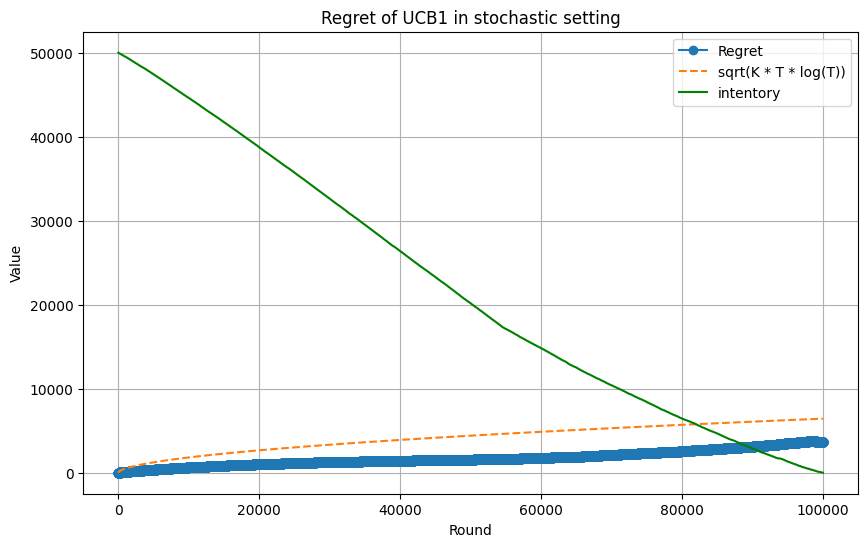

Fitted R(t) ≈ 0.692 * t^0.727, R^2=0.976, p=0.000, std_err=0.000


In [78]:
T = 100_000
B = int(T/2)
log_inventory = np.zeros(T, dtype=int)
agent = UCB1Agent(T=T)
env = StochasticEnvironment(cost = 5, var = 20, T = T, K = 1)

# Store rewards and optimal rewards
rewards = []

# Simulate rounds
for i in range(T):
    p = agent.pull_arm(B)
    r = env.round(p)
    if r > 0:
        B -= 1

    log_inventory[i] = B
    rewards.append(r)
    agent.update(r)

# Calculate regret
regret = compute_regret(env=env, B=log_inventory[0], T=T, rewards=rewards)

# Calculate regret bound
t_values = np.arange(1, T + 1)
bound = np.sqrt(K * np.log(t_values) * t_values)

# Plot regret graph
plt.figure(figsize=(10, 6))
plt.plot(t_values, regret, marker='o', label='Regret')
plt.plot(t_values, bound, label='sqrt(K * T * log(T))', linestyle='--')
plt.plot(t_values, log_inventory, label='intentory', color='green')
plt.xlabel('Round')
plt.ylabel('Value')
plt.title('Regret of UCB1 in stochastic setting')
plt.legend()
plt.grid(True)
plt.show()

sublinearity_check(regret, t_values)

/tmp/ipython-input-708401974.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sold = int(p_t <= self.valuations[self.t]) # Customer buys if p <= v


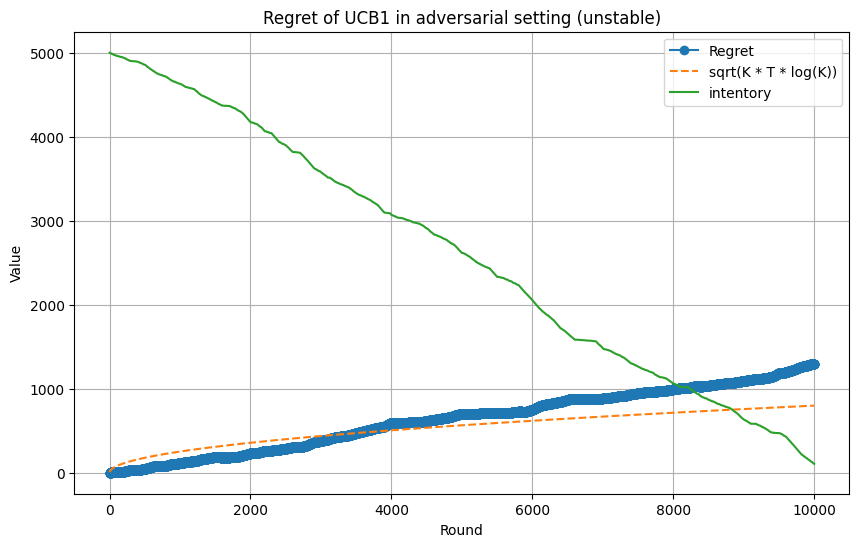

Fitted R(t) ≈ 0.0876 * t^1.043, R^2=0.991, p=0.000, std_err=0.001


In [ ]:
# Initialize variables
T = 10_000
B = int(T/2)
log_inventory = np.zeros(T, dtype=int)
agent = UCB1Agent(T=T)
env = AdversarialEnvironment(cost = 5, step = int(T/100), T = T, K = 1)

# Store rewards and optimal rewards
rewards = []

# Simulate rounds
for i in range(T):
    p = agent.pull_arm(B)
    r = env.round(p)
    if r > 0:
        B -= 1
    log_inventory[i] = B
    rewards.append(r)
    agent.update(r)

# Calculate regret
regret = compute_regret(env=env, B=log_inventory[0], T=T, rewards=rewards)

# Calculate regret bound
t_values = np.arange(1, T + 1)
K = int(1 /( T ** (-1/3)))
bound = np.sqrt(K * np.log(K) * t_values)

# Plot regret graph
plt.figure(figsize=(10, 6))
plt.plot(t_values, regret, marker='o', label='Regret')
plt.plot(t_values, bound, label='sqrt(K * T * log(K))', linestyle='--')
plt.plot(t_values, log_inventory, label='intentory')
plt.xlabel('Round')
plt.ylabel('Value')
plt.title('Regret of UCB1 in adversarial setting (unstable)')
plt.legend()
plt.grid(True)
plt.show()

sublinearity_check(regret, t_values)

### EXP3 Tests

/tmp/ipython-input-708401974.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sold = int(p_t <= self.valuations[self.t]) # Customer buys if p <= v


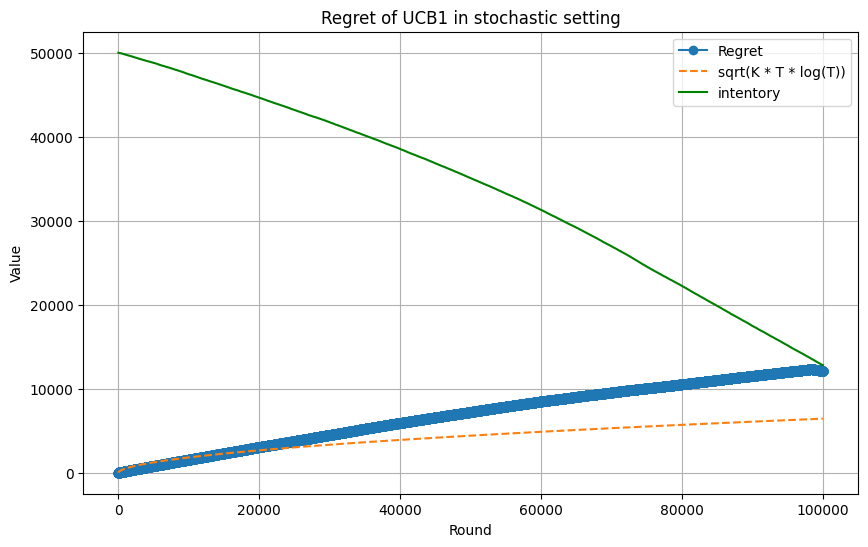

Fitted R(t) ≈ 0.296 * t^0.931, R^2=0.999, p=0.000, std_err=0.000


In [77]:
T = 100_000
B = int(T/2)
log_inventory = np.zeros(T, dtype=int)
agent = EXP3Agent(T=T)
env = StochasticEnvironment(cost = 5, var = 20, T = T, K = 1)

# Store rewards and optimal rewards
rewards = []

# Simulate rounds
for i in range(T):
    p = agent.pull_arm(B)
    r = env.round(p)
    if r > 0:
        B -= 1

    log_inventory[i] = B
    rewards.append(r)
    agent.update(r)

# Calculate regret
regret = compute_regret(env=env, B=log_inventory[0], T=T, rewards=rewards)

# Calculate regret bound
t_values = np.arange(1, T + 1)
bound = np.sqrt(K * np.log(t_values) * t_values)

# Plot regret graph
plt.figure(figsize=(10, 6))
plt.plot(t_values, regret, marker='o', label='Regret')
plt.plot(t_values, bound, label='sqrt(K * T * log(T))', linestyle='--')
plt.plot(t_values, log_inventory, label='intentory', color='green')
plt.xlabel('Round')
plt.ylabel('Value')
plt.title('Regret of UCB1 in stochastic setting')
plt.legend()
plt.grid(True)
plt.show()

sublinearity_check(regret, t_values)

/tmp/ipython-input-708401974.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sold = int(p_t <= self.valuations[self.t]) # Customer buys if p <= v


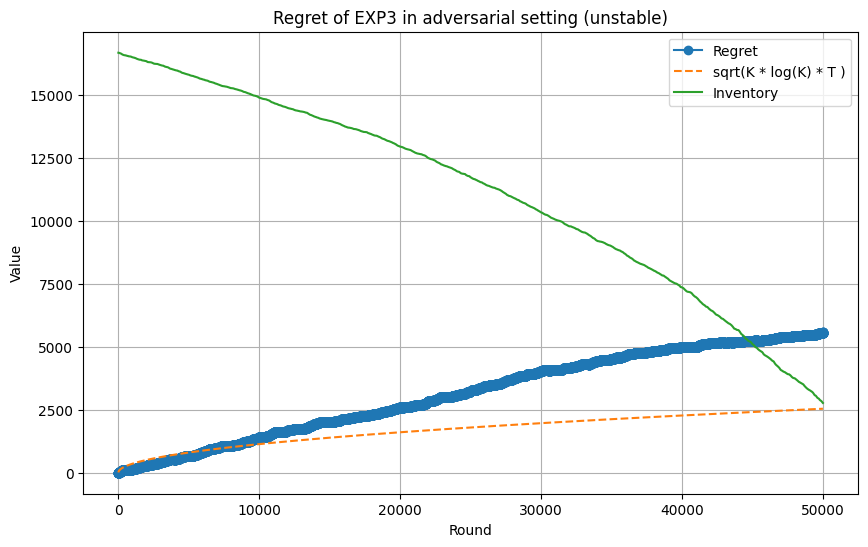

Fitted R(t) ≈ 0.271 * t^0.925, R^2=0.995, p=0.000, std_err=0.000


In [59]:
# Initialize variables
T = 50_000
B = int(T/3)
log_inventory = np.zeros(T, dtype=int)
agent = EXP3Agent(T)
env = AdversarialEnvironment(cost = 5, step = int(T/500), T = T, K = 1)

# Store rewards
rewards = []

# Simulate rounds
for i in range(T):
    p = agent.pull_arm(B)
    r = env.round(p)
    if r > 0:
        B -= 1

    log_inventory[i] = B
    rewards.append(r)
    agent.update(r)

# Calculate regret
regret = compute_regret(env=env, B=log_inventory[0], T=T, rewards=rewards)

# Calculate sqrt(K * log(K) * T )
t_values = np.arange(1, T + 1)
K = int(1 /( T ** (-1/3)))
bound = np.sqrt(K * np.log(K) * t_values)

# Plot regret graph
plt.figure(figsize=(10, 6))
plt.plot(t_values, regret, marker='o', label='Regret')
plt.plot(t_values, bound, label='sqrt(K * log(K) * T )', linestyle='--')
plt.plot(t_values, log_inventory, label='Inventory')
plt.xlabel('Round')
plt.ylabel('Value')
plt.title('Regret of EXP3 in adversarial setting (unstable)')
plt.legend()
plt.grid(True)
plt.show()

sublinearity_check(regret, t_values)

## Coordinators

In [68]:
class Coordinator:
    def __init__(self, T):
        pass

    def choose_agent(self):
        pass

    def update_weights(self, chosen_agent_index, reward):
        pass

    def run(self, env, B):
        for t in range(self.T):
            self.t += 1
            agent, agent_index = self.choose_agent()
            self.N_pulls[agent_index] += 1
            p = agent.pull_arm(B)

            r = env.round(p)
            if r > 0:
                B -= 1
                self.last_sale = t
            self.log_inventory[t] = B

            self.rewards[t] = r
            agent.update(r)
            self.update(agent_index, r)

        # Calculate regret for each agent
        regrets = []
        last_sales = np.zeros(len(self.agents))

        x, last_sales[0] = self.agents[0].compute_regret_B(env, log_inventory[0])
        regrets.append(x)
        x, last_sales[1] = self.agents[1].compute_regret_B(env, log_inventory[0])
        regrets.append(x)

        return regrets

In [69]:
class EXP3Coordinator(Coordinator):
    def __init__(self, T):
        self.T = T
        self.agents = [UCB1Agent(T), EXP3Agent(T)]
        self.N_pulls = np.zeros(len(self.agents))
        self.log_inventory = np.zeros(T)
        self.last_sale = 0
        self.rewards = np.zeros(T)
        self.t = 0

        self.weights = np.ones(len(self.agents))
        self.learning_rate = np.sqrt(np.log(len(self.agents))/(len(self.agents)*T))


    def choose_agent(self):
        probabilities = self.weights / np.sum(self.weights)
        chosen_agent_index = np.random.choice(len(self.agents), p=probabilities)
        return self.agents[chosen_agent_index], chosen_agent_index

    def update(self, chosen_agent_index, reward):
        loss = 1 - reward
        estimated_loss = loss / (self.weights[chosen_agent_index] / np.sum(self.weights))
        self.weights[chosen_agent_index] *= np.exp(-self.learning_rate * estimated_loss)

In [70]:
class UCB1Coordinator(Coordinator):
    def __init__(self, T):
        self.T = T
        self.agents = [UCB1Agent(T), EXP3Agent(T)]
        self.N_pulls = np.zeros(len(self.agents))
        self.log_inventory = np.zeros(T, dtype=int)
        self.last_sale = 0
        self.rewards = np.zeros(T)
        self.t = 0

        self.total_rewards = np.zeros(len(self.agents))

    def choose_agent(self):
        if self.t < len(self.agents):
            chosen_agent_index = self.t
        else:
            ucbs = self.total_rewards / self.N_pulls + np.sqrt(2 * np.log(self.t) / self.N_pulls)
            chosen_agent_index = np.argmax(ucbs)
        return self.agents[chosen_agent_index], chosen_agent_index

    def update(self, chosen_agent_index, reward):
        self.total_rewards[chosen_agent_index] += reward

# Empirical study

## Stochastic setting

/tmp/ipython-input-708401974.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sold = int(p_t <= self.valuations[self.t]) # Customer buys if p <= v
/tmp/ipython-input-3913653768.py:17: RuntimeWarning: invalid value encountered in divide
  ucbs = self.total_rewards / self.N_pulls + np.sqrt(2 * np.log(self.t) / self.N_pulls)
/tmp/ipython-input-3913653768.py:17: RuntimeWarning: divide by zero encountered in divide
  ucbs = self.total_rewards / self.N_pulls + np.sqrt(2 * np.log(self.t) / self.N_pulls)


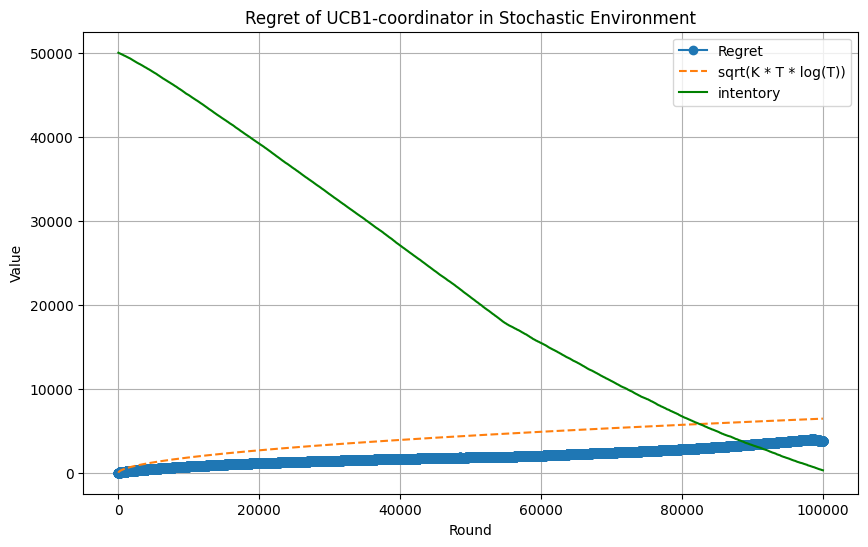

Fitted R(t) ≈ 1.13 * t^0.692, R^2=0.980, p=0.000, std_err=0.000


In [74]:
T = 100_000
B = int(T/2)
coordinator = UCB1Coordinator(T)
env = StochasticEnvironment(cost = 5, var = 20, T = T, K = 1)
coordinator.run(env, B)

regret = compute_regret(env=env, B=B, T=T, rewards=coordinator.rewards)

# Compute regret bound
t_values = np.arange(1, T + 1)
bound = np.sqrt(K * np.log(t_values) * t_values)

# Plotting the regrets for each agent
t_values = np.arange(1, T + 1)
plt.figure(figsize=(10, 6))
plt.plot(t_values, regret, marker='o', label=f'Regret')
plt.plot(t_values, bound, label='sqrt(K * T * log(T))', linestyle='--')
plt.plot(t_values, coordinator.log_inventory, label='intentory', color='green')

plt.xlabel('Round')
plt.ylabel('Value')
plt.title('Regret of UCB1-coordinator in Stochastic Environment')
plt.legend()
plt.grid(True)
plt.show()

sublinearity_check(regret, t_values)

/tmp/ipython-input-708401974.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sold = int(p_t <= self.valuations[self.t]) # Customer buys if p <= v


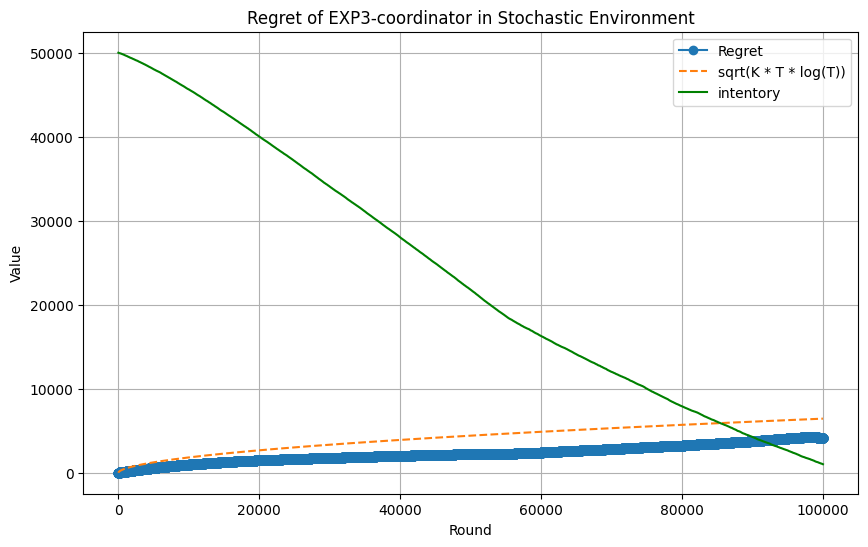

Fitted R(t) ≈ 1.65 * t^0.674, R^2=0.972, p=0.000, std_err=0.000


In [75]:
T = 100_000
B = int(T/2)
coordinator = EXP3Coordinator(T)
env = StochasticEnvironment(cost = 5, var = 20, T = T, K = 1)
coordinator.run(env, B)

regret = compute_regret(env=env, B=B, T=T, rewards=coordinator.rewards)

# Compute regret bound
t_values = np.arange(1, T + 1)
bound = np.sqrt(K * np.log(t_values) * t_values)

# Plotting the regrets for each agent
t_values = np.arange(1, T + 1)
plt.figure(figsize=(10, 6))
plt.plot(t_values, regret, marker='o', label=f'Regret')
plt.plot(t_values, bound, label='sqrt(K * T * log(T))', linestyle='--')
plt.plot(t_values, coordinator.log_inventory, label='intentory', color='green')

plt.xlabel('Round')
plt.ylabel('Value')
plt.title('Regret of EXP3-coordinator in Stochastic Environment')
plt.legend()
plt.grid(True)
plt.show()

sublinearity_check(regret, t_values)

## Adversarial setting

/tmp/ipython-input-708401974.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sold = int(p_t <= self.valuations[self.t]) # Customer buys if p <= v
/tmp/ipython-input-3974837769.py:17: RuntimeWarning: invalid value encountered in divide
  ucbs = self.total_rewards / self.N_pulls + np.sqrt(2 * np.log(self.t) / self.N_pulls)
/tmp/ipython-input-3974837769.py:17: RuntimeWarning: divide by zero encountered in divide
  ucbs = self.total_rewards / self.N_pulls + np.sqrt(2 * np.log(self.t) / self.N_pulls)


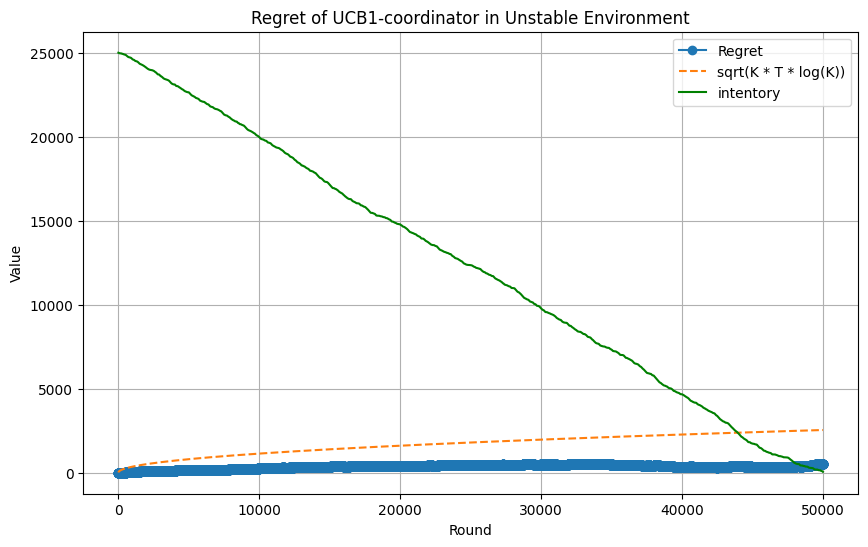

Fitted R(t) ≈ 0.666 * t^0.625, R^2=0.779, p=0.000, std_err=0.001


In [65]:
T = 50_000
B = int(T/2)
coordinator = UCB1Coordinator(T)
env = AdversarialEnvironment(cost = 5, step = int(T/500), T = T, K = 1)
coordinator.run(env, B)

regret = compute_regret(env=env, B=B, T=T, rewards=coordinator.rewards)

# Compute regret bound
t_values = np.arange(1, T + 1)
bound = np.sqrt(K * np.log(K) * t_values)

# Plotting the regrets for each agent
t_values = np.arange(1, T + 1)
plt.figure(figsize=(10, 6))
plt.plot(t_values, regret, marker='o', label=f'Regret')
plt.plot(t_values, bound, label='sqrt(K * T * log(K))', linestyle='--')
plt.plot(t_values, coordinator.log_inventory, label='intentory', color='green')

plt.xlabel('Round')
plt.ylabel('Value')
plt.title('Regret of UCB1-coordinator in Unstable Environment')
plt.legend()
plt.grid(True)
plt.show()

sublinearity_check(regret, t_values)

/tmp/ipython-input-708401974.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sold = int(p_t <= self.valuations[self.t]) # Customer buys if p <= v


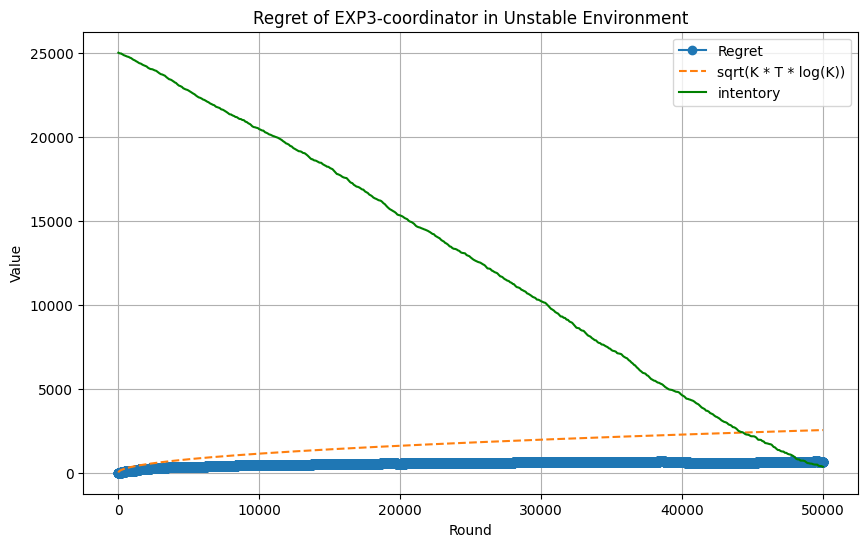

Fitted R(t) ≈ 7.83 * t^0.424, R^2=0.839, p=0.000, std_err=0.001


In [71]:
T = 50_000
B = int(T/2)
coordinator = EXP3Coordinator(T)
env = AdversarialEnvironment(cost = 5, step = int(T/500), T = T, K = 1)
coordinator.run(env, B)

regret = compute_regret(env=env, B=B, T=T, rewards=coordinator.rewards)

# Compute regret bound
t_values = np.arange(1, T + 1)
bound = np.sqrt(K * np.log(K) * t_values)

# Plotting the regrets for each agent
t_values = np.arange(1, T + 1)
plt.figure(figsize=(10, 6))
plt.plot(t_values, regret, marker='o', label=f'Regret')
plt.plot(t_values, bound, label='sqrt(K * T * log(K))', linestyle='--')
plt.plot(t_values, coordinator.log_inventory, label='intentory', color='green')

plt.xlabel('Round')
plt.ylabel('Value')
plt.title('Regret of EXP3-coordinator in Unstable Environment')
plt.legend()
plt.grid(True)
plt.show()

sublinearity_check(regret, t_values)